In [45]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os, os.path
import pickle
import numpy
from scipy import interpolate
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
%pylab inline
from matplotlib import cm
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [2]:
pos_radec, rvel_ra= pal5_util.pal5_data()

## Some convenience functions

In [3]:
def width_trailing(sdf):
    """Return the FWHM width in arcmin for the trailing tail"""
    # Go out to RA=245 deg
    trackRADec_trailing=\
        bovy_coords.lb_to_radec(sdf._interpolatedObsTrackLB[:,0],
                                sdf._interpolatedObsTrackLB[:,1],
                                degree=True)
    cindx= range(len(trackRADec_trailing))[numpy.argmin(numpy.fabs(trackRADec_trailing[:,0]-245.))]
    ws= numpy.zeros(cindx)
    for ii,cc in enumerate(range(1,cindx+1)):
        xy= [sdf._interpolatedObsTrackLB[cc,0],None,None,None,None,None]
        ws[ii]= numpy.sqrt(sdf.gaussApprox(xy=xy,lb=True,cindx=cc)[1][0,0])
#    return 2.355*60.*ws
    return 2.355*60.*numpy.mean(ws)

In [93]:
def plot_data_add_labels(color=sns.color_palette()[2]):
    subplot(1,2,1)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
    xlim(250.,220.)
    ylim(-5.,9.)
#    xlim(230.,225.)
#    ylim(-1.5,1.5)
    bovy_plot._add_ticks()
    errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
             ls='none',marker='o',color=color)
    subplot(1,2,2)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    xlim(250.,220.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

## The fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [5]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
sigv= 0.4

In [6]:
sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                       pot=pot,aA=aAI,
                       leading=False,nTrackChunks=11,
                       tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                       ro=ro,vo=vo,R0=ro,
                       vsun=[-11.1,vo+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/vo,progenitor=prog,
                      pot=pot,aA=aAI,
                      leading=True,nTrackChunks=11,
                      tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                      ro=ro,vo=vo,R0=ro,
                      vsun=[-11.1,vo+24.,7.25],
                      custom_transform=pal5_util._TPAL5)

In [21]:
threshold= 0.3
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold))
print "Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing))

Angular length: 71.542095 deg (leading,trailing)=(44.201146,27.340949) deg
Angular width (FWHM): 19.012902 arcmin


In [8]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

What is the observed length?

In [24]:
# Pretend to find the length
peak_dens= sdf_trailing.density_par(0.1,coord='customra')
trackxieta_trailing=\
    pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                                 trackRADec_trailing[:,1],degree=True)
theta_end= numpy.interp(15.,trackxieta_trailing[:,0],
                    sdf_trailing._interpolatedThetasTrack)
end_dens= sdf_trailing.density_par(theta_end,coord='customra')
print "Pal 5's trailing tail is at least %.1f degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree" \
    % sdf_trailing.length(threshold=end_dens/peak_dens,coord='customra',ang=True)

Pal 5's trailing tail is at least 21.3 degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree


<Container object of 3 artists>

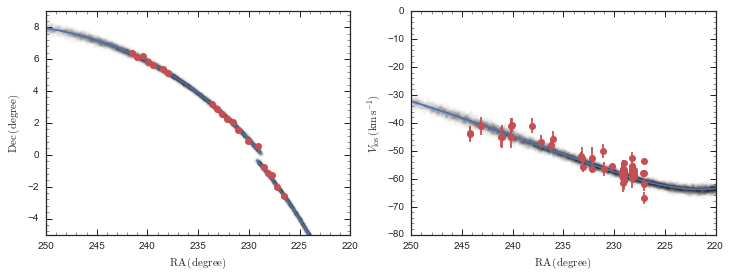

In [9]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

## The orbit of Pal 5 in different flattened and triaxial potentials

In [9]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [10]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

Vary $c$ along the best-fit line:

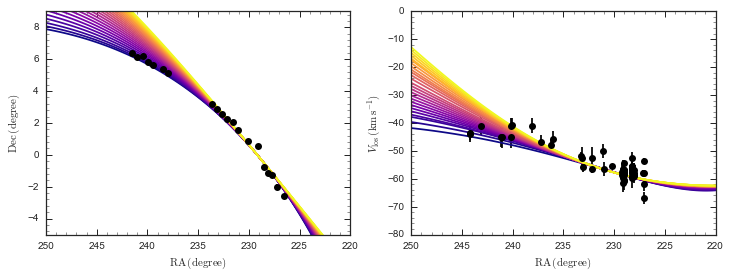

In [12]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')

## How does the track, width, and length of the Pal 5 stream vary with the potential?

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [184]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

In [154]:
reload(pal5_util)
out= pal5_util.pal5_lnlike(pos_radec,rvel_ra,*pal5varyc)

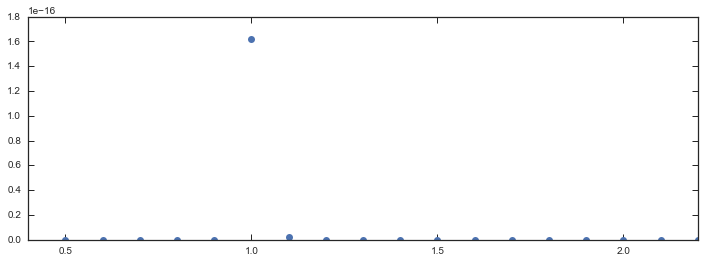

In [155]:
plot(cs,numpy.exp(numpy.sum(out[:,:3],axis=1)),'o')

In [156]:
numpy.arange(0.5,2.6,0.1)

array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5])

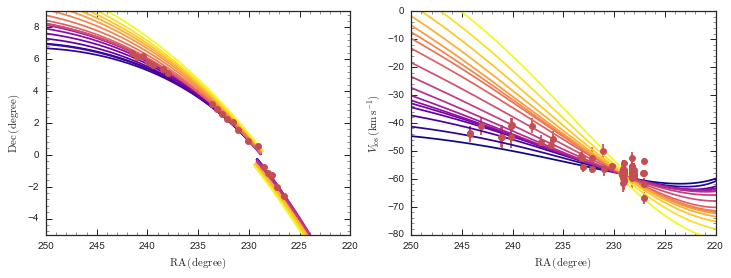

In [157]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()

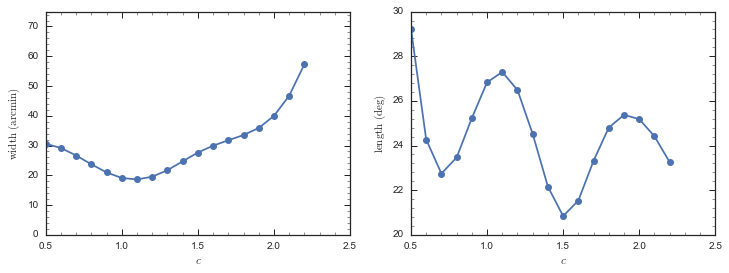

In [158]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Let's now try to make all streams 18' wide and 25 degree long:

In [185]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-constwl.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_constwl= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    interpcs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    ipw= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[4],k=3)
    ipl= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[5],k=3)
    sigv=0.4*18./ipw(interpcs)
    td=5.*25./ipl(interpcs)/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_constwl= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                                 interpcs=interpcs,
                                                 sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_constwl)

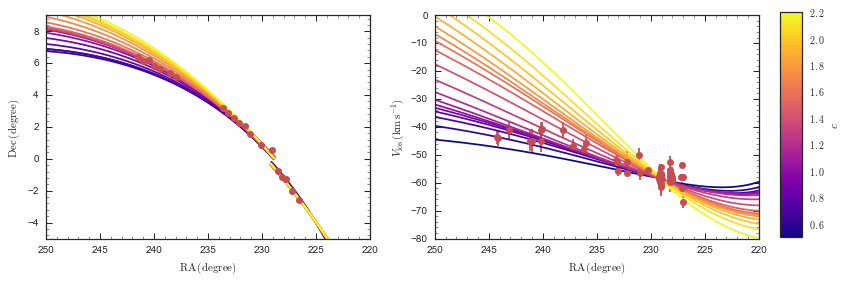

In [186]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Directly compare a subset ($c=0.5$ to $2.1$ in $0.2$ increments):

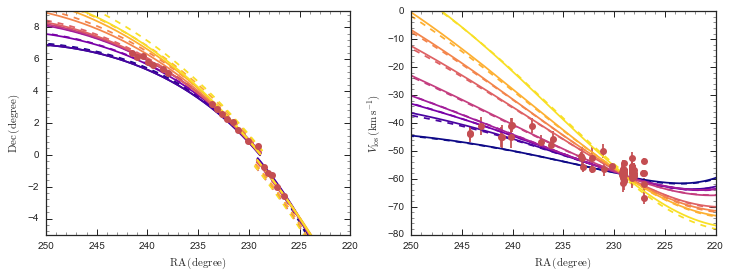

In [187]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs[::2]):
    ii*= 2
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
plot_data_add_labels()

The differences are small, especially around $c\approx1$. The width and length of the stream, pre-correction in green:

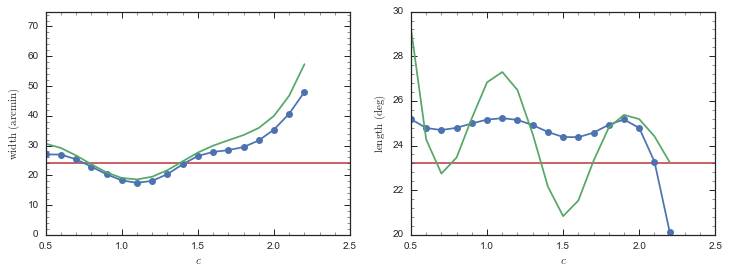

In [188]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

It appears that the increase in the stream age undoes the effect of making the stream colder on the width of the stream. This raises the question whether it is at all possible to have a long, cold stream in these $c\neq1$ potentials.

A test with double the number of track points, to see whether that matters. It does not:

In [162]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-ntc16.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=16,nTrackChunks=16,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

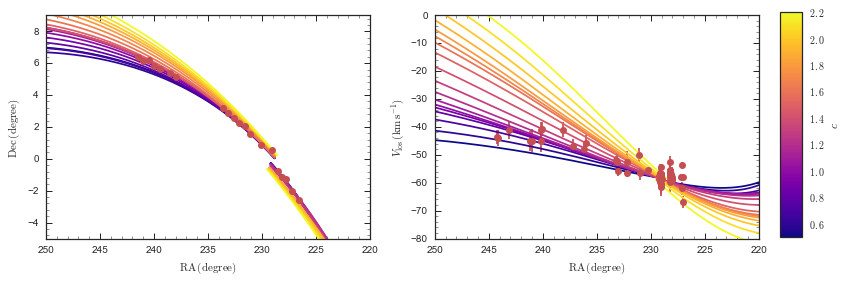

In [163]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Let's take a look at the grid-points themselves, to see whether the same trend shows for them. They do:

In [173]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-singlec.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.55,1.75,2.,2.25])
    trackRADec_trailing_out= numpy.empty((len(cs),1001,2))
    trackRADec_leading_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_trailing_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_leading_out= numpy.empty((len(cs),1001,2))
    width_out= numpy.empty(len(cs))
    length_out= numpy.empty(len(cs))
    for ii,c in enumerate(cs):
        tpal5varyc= pal5_util.predict_pal5obs(p_b15,c,multi=8,singlec=True)
        trackRADec_trailing_out[ii]= tpal5varyc[0]
        trackRADec_leading_out[ii]= tpal5varyc[1]
        trackRAVlos_trailing_out[ii]= tpal5varyc[2]
        trackRAVlos_leading_out[ii]= tpal5varyc[3]
        width_out[ii]= tpal5varyc[4]
        length_out[ii]= tpal5varyc[5]
    pal5varyc= (trackRADec_trailing_out,trackRADec_leading_out,
                trackRAVlos_trailing_out,trackRAVlos_leading_out,
                width_out,length_out)
    save_pickles(savefilename,cs,pal5varyc)

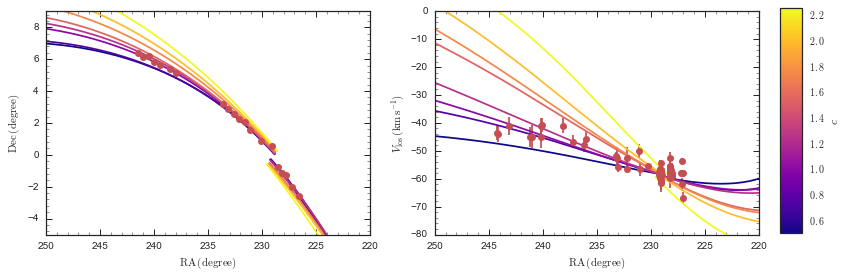

In [174]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

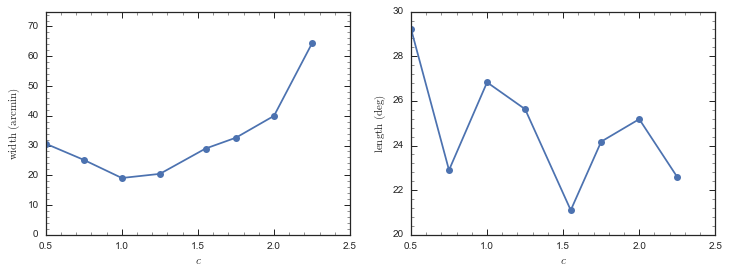

In [175]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

What happens when we use a denser interpolation grid?

In [189]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-densergrid.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.05)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.,2.1,2.2])
    save_pickles(savefilename,cs,pal5varyc)

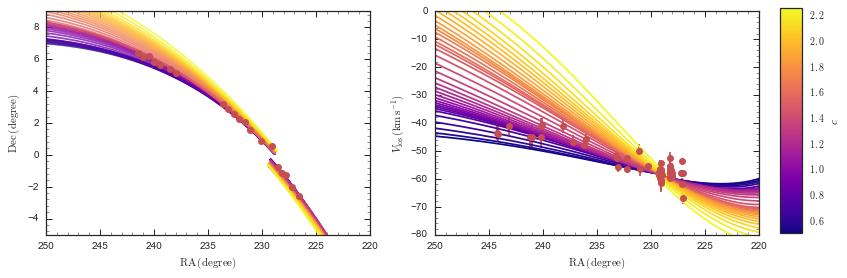

In [190]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

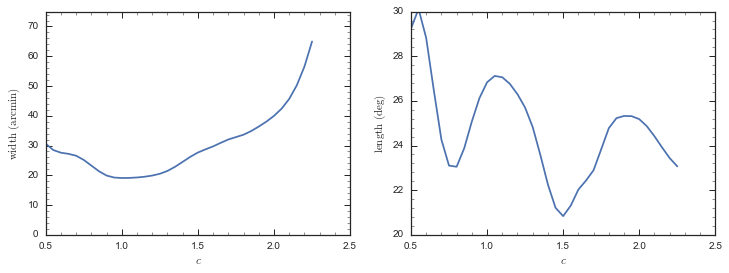

In [191]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Does this change for different potential parameters?

In [112]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-shortscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

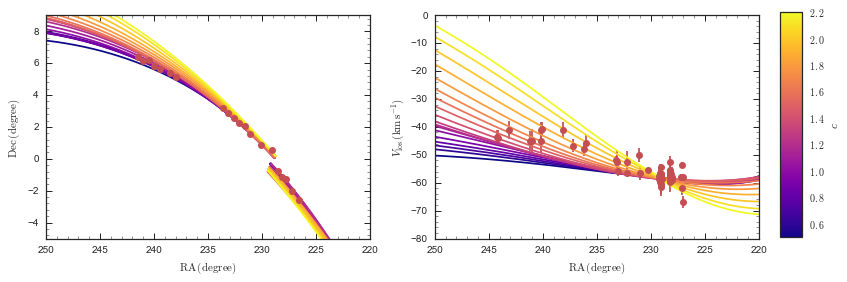

In [113]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < .95 or (c > 1.05 and c < 1.25): continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

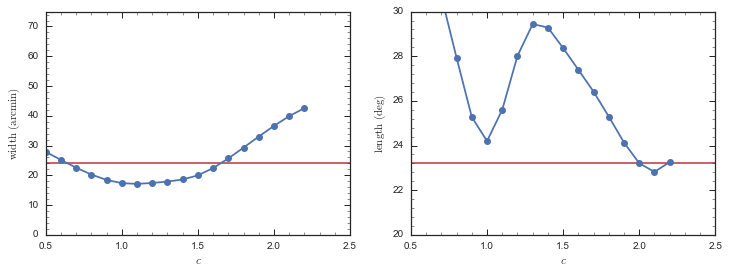

In [108]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another different potential:

In [219]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-longscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

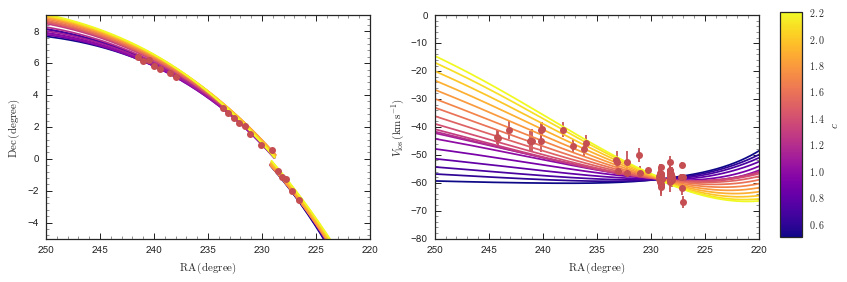

In [220]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

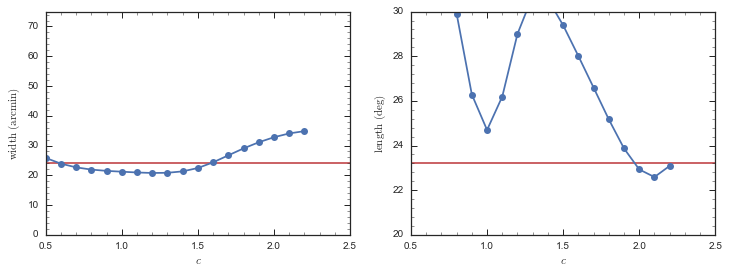

In [125]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another one to test:

In [150]:
p_b15= [0.45,0.45,-1.,-3.2,0.9,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-somescale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

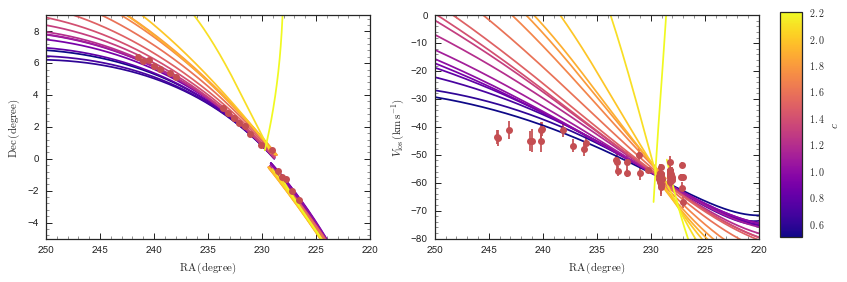

In [151]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

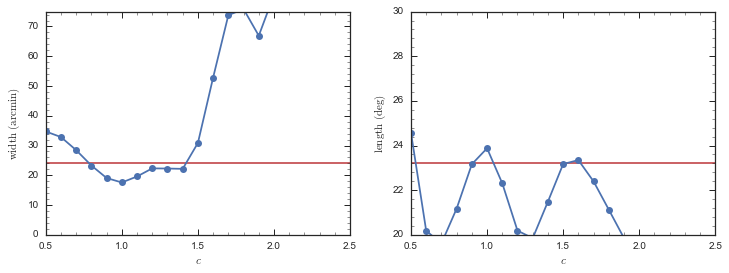

In [152]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## Some likelihoods for fixed sets of parameters

In [221]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-like.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_like= pickle.load(savefile)
else:
    # First just compute the interpolation points, to adjust the width and length
    interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25]
    pal5varyc= pal5_util.predict_pal5obs(p_b15,interpcs,multi=8,interpcs=interpcs)
    cs= numpy.arange(0.5,2.21,0.01)
    sigv=0.4*18./pal5varyc[4]
    td=5.*25./pal5varyc[5]/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_like= pal5_util.predict_pal5obs(p_b15,cs,multi=8,interpcs=pal5varyc[6],
                                              sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_like)

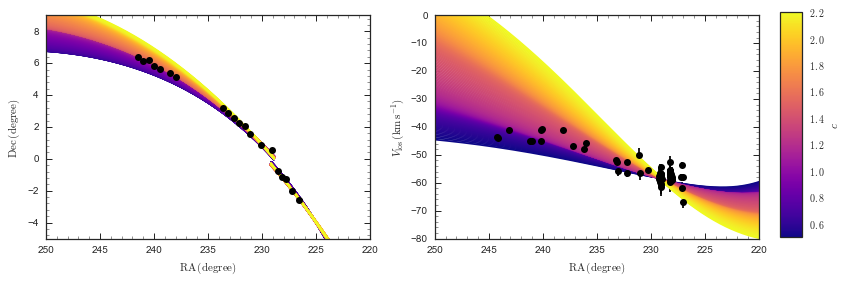

In [225]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_like[0][ii,:,0],
                        pal5varyc_like[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[1][ii,:,0],
                        pal5varyc_like[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_like[2][ii,:,0],
                        pal5varyc_like[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[3][ii,:,0],
                        pal5varyc_like[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels('k')
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

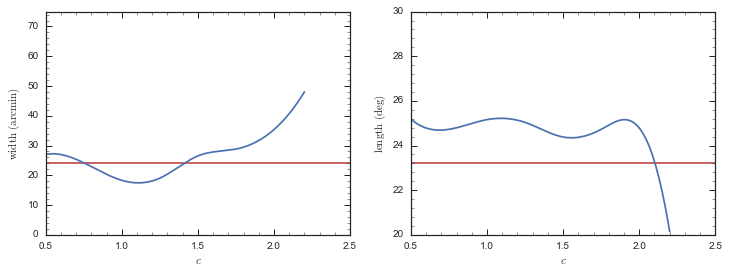

In [195]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_like[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_like[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

In [200]:
reload(pal5_util)
out= pal5_util.pal5_lnlike(pos_radec,rvel_ra,*pal5varyc_like)

Mode, mean, std.dev., P(c<1): 1.04 1.05034136858 0.0301829291315 0.0416808139734


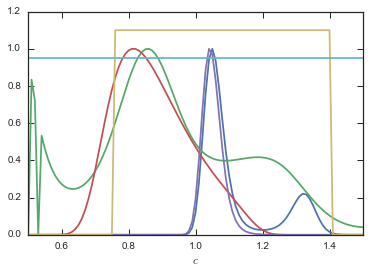

In [218]:
figsize(6,4)
plot(cs,numpy.exp(out[:,0]-numpy.amax(out[:,0])))
plot(cs,numpy.exp(out[:,1]-numpy.amax(out[:,1])))
plot(cs,numpy.exp(out[:,2]-numpy.amax(out[:,2])))
comb= numpy.exp(numpy.sum(out[:,:3],axis=1)-numpy.amax(numpy.sum(out[:,:3],axis=1)))
comb[out[:,3] > 24.]= 0.
comb[out[:,4] < 23.2]= 0.
plot(cs,comb)
m= numpy.sum(cs*comb)/numpy.sum(comb)
plot(cs,(out[:,3] < 24.)*1.1)
plot(cs,(out[:,4] > 23.2)*0.95)
xlabel(r'$c$')
xlim(0.5,1.5)
ylim(0.,1.2)
print "Mode, mean, std.dev., P(c<1):" ,\
    cs[numpy.argmax(comb)], m, numpy.sqrt(numpy.sum((cs-m)**2.*comb)/numpy.sum(comb)), \
    numpy.cumsum(comb/numpy.sum(comb))[numpy.fabs(cs-1.) < 0.005][0]